In [ ]:
import cv2
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from glob import glob

In [38]:

def extract_grid_mask(img, closing_kernel=5, length_frac=0.8):
    """
    img:       BGR or grayscale input
    closing_kernel: size of small kernel to close grid dots ([3,3] works well)
    length_frac: fraction of img width/height that a line must span to be kept
    """
    # 1) Grayscale + adaptive threshold
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if img.ndim==3 else img
    binarized = cv2.adaptiveThreshold(gray,255,
                                      cv2.ADAPTIVE_THRESH_MEAN_C,
                                      cv2.THRESH_BINARY_INV,
                                      blockSize=51, C=10)

    # 2) Close gaps (connect dots into lines)
    kernel_close = np.ones((closing_kernel, closing_kernel), np.uint8)
    closed = cv2.morphologyEx(binarized, cv2.MORPH_CLOSE, kernel_close)

    h, w = gray.shape

    # 3a) Extract horizontal lines via opening
    horiz_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(w*0.5), 1))
    horiz_lines = cv2.morphologyEx(closed, cv2.MORPH_OPEN, horiz_kernel)

    # 3b) Extract vertical lines via opening
    vert_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(h*0.5)))
    vert_lines = cv2.morphologyEx(closed, cv2.MORPH_OPEN, vert_kernel)

    # 4) Filter by length: remove any connected component shorter than threshold
    def filter_by_length(mask, axis_len):
        # keep only components whose bounding‐box along axis >= length_frac*axis_len
        nb_components, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
        out = np.zeros_like(mask)
        min_len = length_frac * axis_len
        for i in range(1, nb_components):
            x, y, w0, h0, area = stats[i]
            if axis_len==w:    # horizontal mask
                if w0 >= min_len:
                    out[labels==i] = 255
            else:              # vertical mask
                if h0 >= min_len:
                    out[labels==i] = 255
        return out

    horiz_clean = filter_by_length(horiz_lines, w)
    vert_clean  = filter_by_length(vert_lines,  h)

    # 5) Combine
    grid_mask = cv2.bitwise_or(horiz_clean, vert_clean)
    return grid_mask


def visualize(image, grid_mask):
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))
    axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Original")
    axs[1].imshow(grid_mask, cmap='gray')
    axs[1].set_title("Detected Grid")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [58]:
# === Directory Config ===
IMAGE_DIR = '../data/overlap-dataset/with-overlap/image'  # change to your folder
img_paths = glob(os.path.join(IMAGE_DIR, '*.png')) + glob(os.path.join(IMAGE_DIR, '*.jpg'))
sample_paths = random.sample(img_paths, min(5, len(img_paths)))

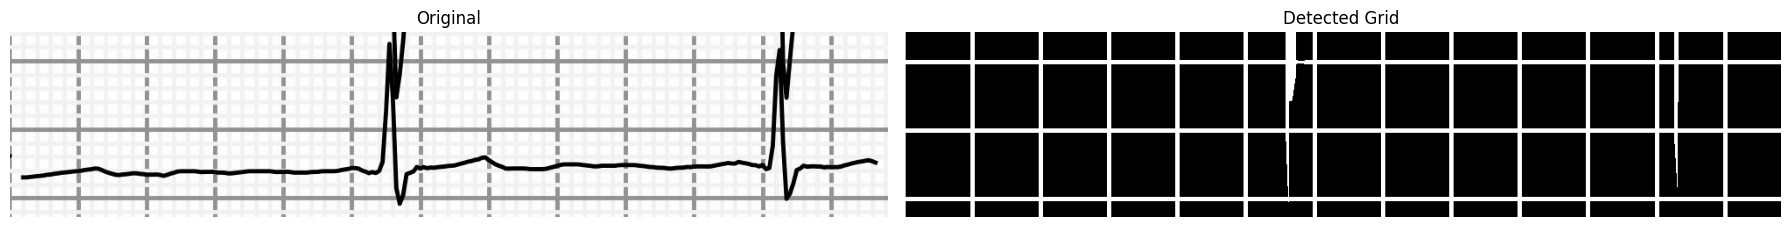

Average square width:  66.2 px
Average square height: 78.0 px
Average square size:   78.0 px


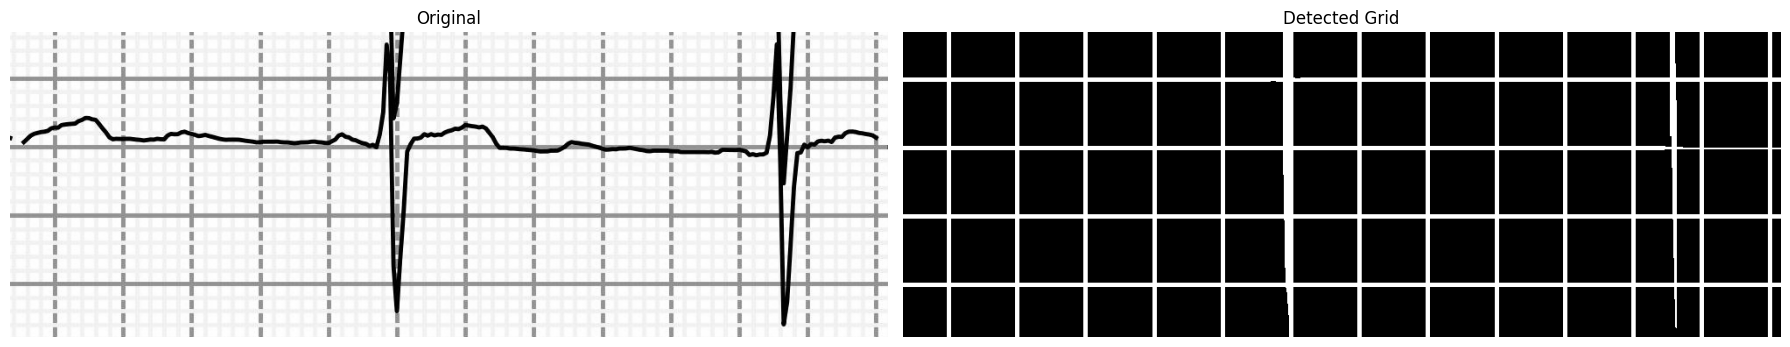

Average square width:  72.2 px
Average square height: 58.5 px
Average square size:   72.2 px


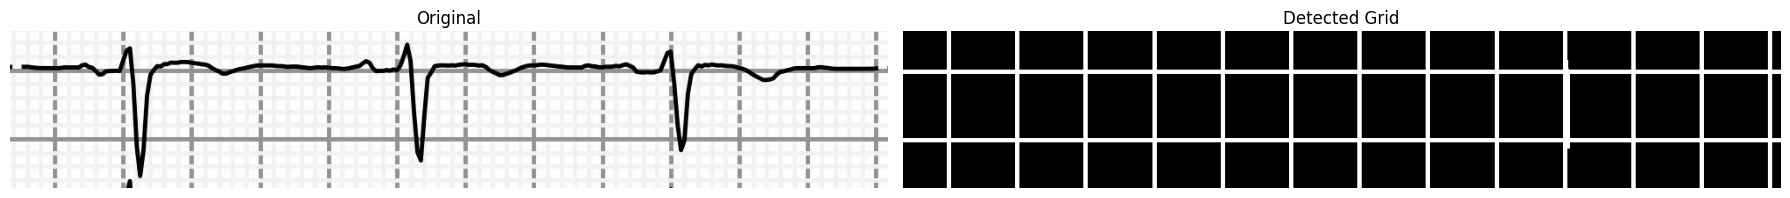

Average square width:  78.2 px
Average square height: 78.0 px
Average square size:   78.2 px


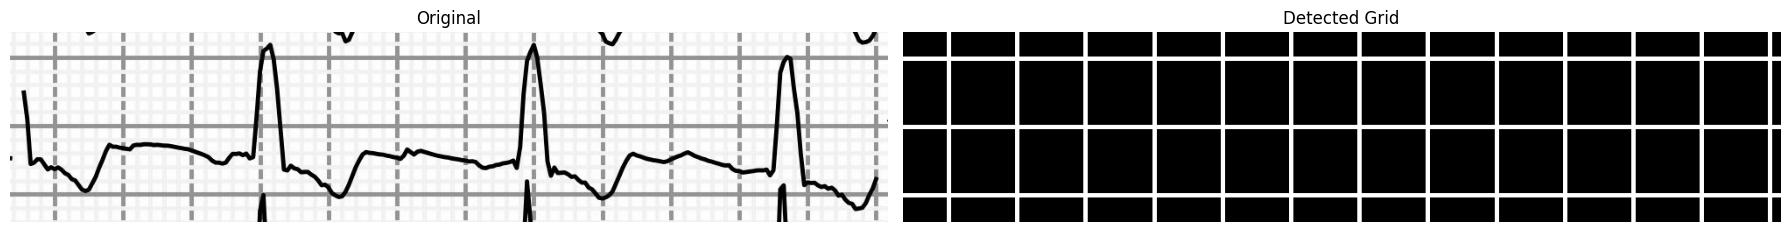

Average square width:  78.2 px
Average square height: 78.0 px
Average square size:   78.2 px


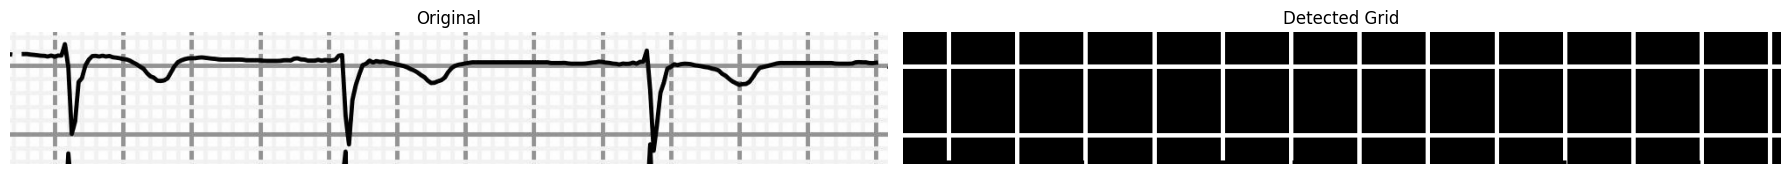

Average square width:  78.2 px
Average square height: 78.0 px
Average square size:   78.2 px


In [ ]:
from scipy.signal import find_peaks
images = []
masks = []
# === Process & Visualize ===
for path in sample_paths:
    img = cv2.imread(path)
    images.append(img)
    if img is None:
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    grid_mask = extract_grid_mask(img, closing_kernel=6)


    masks.append(grid_mask)

    visualize(img, grid_mask)

    # 1) Project onto each axis
    vertical_profile   = grid_mask.sum(axis=0)   # sum over rows → strong peaks at vertical lines
    horizontal_profile = grid_mask.sum(axis=1)   # sum over cols → strong peaks at horizontal lines

    # 2) Find the line positions (peaks)
    #    height thresholds assume lines span most of the image
    v_peaks, _ = find_peaks(vertical_profile, height=grid_mask.shape[0] * 0.5)
    h_peaks, _ = find_peaks(horizontal_profile, height=grid_mask.shape[1] * 0.5)

    # 3) Compute spacings between consecutive peaks
    v_spacings = np.diff(v_peaks)   # pixel widths between vertical lines
    h_spacings = np.diff(h_peaks)   # pixel heights between horizontal lines

    # 4) Take the average (or median) spacing
    avg_square_width  = v_spacings.mean()
    avg_square_height = h_spacings.mean()
    square_size = max( avg_square_width , avg_square_height )  # we use max here bcz in most of the cases the squares have waves in between them 
    
    

    print(f"Average square width:  {avg_square_width:.1f} px")
    print(f"Average square height: {avg_square_height:.1f} px")
    print(f"Average square size:   {square_size:.1f} px")